# Summary/Theory

This file serves as a demo for the contrast transfer function (CTF) in a transmission electron microscope. It is based on chapter 9 in the companion volume to William and Carter. 

The contrast transfer function is a useful tool to analyze how the objective lens impacts the final image that is recorded from a specimen. Each point on the exit surface of the specimen emits spherical waves (Huygen's principle) that together make up some exit wave $\Phi_0(r)$, most conveniently described by complex numbers. This wave propagates down the column through the objective lens. At some plane below the objective lens we will have a wave function $\Phi_1(r)$. Because beams traveling at different directions into the objective lens get focussed differently, initially spherical wavefronts will be slightly bent. One can also view this as a path difference $\chi$ manifesting for beams of different $g$. Expressing the wave function in recyprocal space, this implies:

$\Phi_1(g) = \Phi_0(g) \exp(-i \chi(g))$

$\chi(g)$ is the aberation function and is typically expressed as

$\chi(g) =  2 \pi \left(\frac{1}{4} C_s \lambda^3 g^4 + \frac{1}{2}\Delta f \lambda g^2\right)$

With $C_s$ the spherical aberation constant, $\lambda$ the electron wave length, $\Delta f$ the defocus

You can show that for a weak phase object the image intensity at a particular $g$ is equal to

$I_L(g) = \Phi_1 \Phi_1^* \approx 2 \mathcal{F}\{\text{Im}(\Phi_0(r))\}\sin(\chi(g))$

The **coherent contrast transfer function (CTF)** is the $\sin(\chi(g))$ factor. It describes how well the fourrier coefficient with wavevector $g$ of the imaginary part of the real space wave function is transfered into the image.

The CTF oscillates, and it starts oscillating more and more at higher frequencies $g$. This is bad because it becomes impossible to interpret contrast. We can make the region in the beginning oscillate less by compensating spherical aberation with defocus. The defocus value where we can keep the region between 0 and the first zero kind of close to -1 is the *Scherzer defocus*. It is calculated as

$\Delta f_{Scherzer} = -\sqrt{\frac{4}{3}C_s \lambda}$

The value where the CTF first crosses the x-axis at Scherzer defocus is $g_s$ the point resolution. Up to $g_s$, details in the images, at least in weak phase objects, can be directly interpreted as the negative imaginary part of the exit wave $\Phi_0(g)$.

$g_s = \left(\frac{3}{16} C_s \lambda^3\right)$

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.widgets as wdgts

In [12]:
%matplotlib notebook

In [54]:
def wavelength(kv):
    """Get the electron wavelength in nm from the high voltage in kV"""
    # ht in Volts, length unit in meters
    ht = kv*1000
    h = 6.6e-34
    m = 9.1e-31
    charge = 1.6e-19
    c = 3e8
    wavelength = h / math.sqrt(2 * m * charge * ht)
    relativistic_correction = 1 / math.sqrt(1 + ht * charge/(2 * m * c * c))
    return wavelength * relativistic_correction*1e9

def spherical_aberation(g, cs, wl):
    """spherical aberation term"""
    return 1/4*cs*wl**3*g**4

def focus_aberation(g, df, wl):
    """defocus aberation term"""
    return 1/2*df*wl*g**2

def abberation(g, cs, df, wl):
    """total aberation function chi"""
    sa = spherical_aberation(g, cs, wl)
    fa = focus_aberation(g, df, wl)
    return 2*np.pi*(sa+fa)

def ctf(g, cs, df, wl):
    """coherent contrast transfer function"""
    chi = abberation(g, cs, df, wl)
    return np.sin(chi)

def sherzer_f(cs, wl):
    """sherzer defocus, returns focus and point resolution g"""
    sf = -(4/3*cs*wl)**0.5
    gs = (3/16*cs*wl**3)**(-0.25)
    return sf, gs

Coherent contrast transfer is not the full story. Due to the finite size and energy spread of the electron source, spatial and temporal coherence also come into play in contrast transfer. The book is quite vague on the details, but their net effect is to act as an "envelope" function that dampens the CTF at high frequencies.

I found expressions for the spatial and temporal envelope functions in <https://www.sciencedirect.com/science/article/pii/B9780080967011000343>. They require parameters $\beta_i$ (illumination angle) and $\Delta$ (defocus spread - depends on chromatic aberation and source energy spread) which must be measured experimentally in the microscope. Nowhere did I find reasonable ranges for these parameters so I just guessed them to get curves and values similar as in the books.

The envelope functions are multiplied with the CCTF to yield the damped transfer function. The information limit $g_{max}$ is typically defined as the frequency where the envelope function falls below 1/e$^2 \approx$ 0.13. Beyond this frequency, we assume no more useful information can be transfered into the image.

The Scherzer defocus may not be the optimal defocus for imaging in all cases because it results in a large gradient of $\chi$, which translates itself into a wide point spread function. The point spread function causes points in $\Phi_0$ to be blurred and smeared out in $\Phi_1$. The focus value where we have the smallest point spread function (the different $g$ rays are best focused to a point) is the Lichte defocus $\Delta f_{opt}$.

$\Delta f_{opt} = -\frac{3}{4}C_s\lambda^2 g_{max}^2$

The radius of the PSF is given by

$R_{PSF} = max(|C_s \lambda^3 g^3 + \Delta f \lambda g|) $

With g being the furthest out beam. This is either $g_{max}$ or $g_{s}$. 

In [119]:
from scipy.optimize import root

def envelope_S(g, cs, wl, df, beta_i):
    """Spatial coherence envelope function (considers finite size of source)"""
    return np.exp(-(np.pi*beta_i/wl)*(cs*wl**3*g**2-df*wl)**2)

def envelope_T(g, wl, delta):
    """Temporal coherence envelope function (considers C_c)"""
    return np.exp(-(np.pi*wl*delta*g**2/2)**2)

def get_gmax(cs, wl, df, beta_i, delta, x0=0):
    """Get the information limit"""
    xx = lambda x: envelope_S(x, cs, wl, df, beta_i)*envelope_T(x, wl, delta)-0.13
    return root(xx, x0=x0, method="excitingmixing")

def optimalZ(cs, wl, gmax):
    """Get the focus of least confusion"""
    return -3/4*cs*wl**2*gmax**2

**Below is plot**:

* The CCTF
* Both envelope functions
* The damped CTF
* Point resolution and information limit

You can see how all of these change whey you change:

* defocus
* $C_s$
* High tension

On the defocus slider is also plot the Scherzer (red) and Lichte (green) defocus

You may have to change the $g$ grid (line 7) below when you want to look at aberation corrected vs non-aberation corrected

<IPython.core.display.Javascript object>


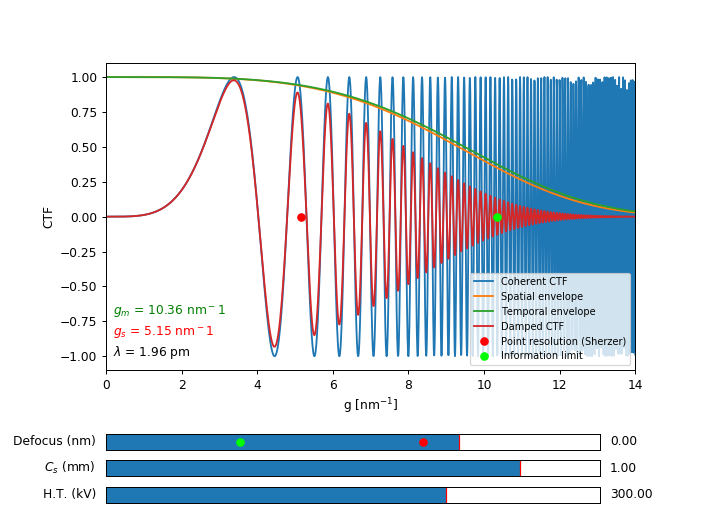

In [129]:
#plot it
fig, ax = plt.subplots(figsize=(8, 6))
axwidth = 0.7
plt.subplots_adjust(bottom=0.3, left=0.5-axwidth/2)

#Setting initial conditions
g = np.linspace(0, 14, 2000)
cs0= 1
df0 = 0
v0 = 300
wl0 = wavelength(v0)

#Vary these parameters to control envelope function
beta_i = 0.001
delta = 3

#calculating the envelopes and CCTF
envs = envelope_S(g, cs0*1e6, wl0, df0, beta_i)
temps = envelope_T(g, wl0, delta)
ct = ctf(g, cs0*1e6, df0, wl0)

lim, = ax.plot(g, ct, label="Coherent CTF")
# spatial coherence envelope function
lim2, = ax.plot(g, envs, label="Spatial envelope")
# temporal coherence envelope function
lim3, = ax.plot(g, temps, label="Temporal envelope")
lim4, = ax.plot(g, temps*envs*ct, label="Damped CTF")
# show also lambda on the axis as text
lamtex = ax.text(0.2, -1, f"$\lambda$ = {round(wl0*1000, 2)} pm")

# plot the sherzer defocus
sf, gs = sherzer_f(cs0*1e6, wl0)
# calculate gmax
gx = float(get_gmax(cs0*1e6, wl0, df0, beta_i, delta).x)
# calculate optimal defocus for gmax
zlc = optimalZ(cs0*1e6, wl0, gx)
# show values on the axis as text
gstex = ax.text(0.2, -0.85, f"$g_s$ = {round(gs, 2)} nm$^{-1}$", color = "red")
gmaxtex = ax.text(0.2, -0.7, f"$g_m$ = {round(gx, 2)} nm$^{-1}$", color = "green")
# point spread function radius
#R = Rpsf(gx, gs, df0, cs0*1e6, wl0)
#rtex = ax.text(0.2, -0.55, f"$R_p$ = {round(R, 2)} nm$^{-1}$")

optfoc, = ax.plot([gs], [0], color="red", marker = "o", linestyle="", label="Point resolution (Sherzer)")
infolim, = ax.plot([gx], [0], color=(0, 1, 0), marker = "o", linestyle="", label="Information limit")

ax.margins(x=0)
axcolor = 'white'
axheight = 0.03
axfram = plt.axes([0.5-axwidth/2, 0.15, axwidth, axheight],
                  facecolor=axcolor)
axmax = plt.axes([0.5-axwidth/2, 0.10, axwidth, axheight],
                 facecolor=axcolor)
axmin = plt.axes([0.5-axwidth/2, 0.05, axwidth, axheight],
                 facecolor=axcolor)

sfam = wdgts.Slider(axfram, 'Defocus (nm)', -500, 200, valinit=df0)
smax = wdgts.Slider(axmax, '$C_s$ (mm)', -0.04, 1.2, valinit=cs0)
smin = wdgts.Slider(axmin, 'H.T. (kV)', 80, 400, valinit=v0)

optfoc_2, = axfram.plot([sf], [0], color="red", marker = "o", linestyle="")
infolimfoc_2, = axfram.plot([zlc], [0], color=(0,1,0), marker = "o", linestyle="")

def update(val):
    csn = smax.val
    vn = smin.val
    dfn = sfam.val
    wln = wavelength(vn)
    wlt = f"$\lambda$ = {round(wln*1000, 2)} pm"
    ctn = ctf(g, csn*1e6, dfn, wln)
    envs = envelope_S(g, csn*1e6, wln, dfn, beta_i)
    temps = envelope_T(g, wln, delta)
    lim.set_ydata(ctn)
    lim2.set_ydata(envs)
    lim3.set_ydata(temps)
    lim4.set_ydata(ctn*envs*temps)
    lamtex.set_text(wlt)
    gx = float(get_gmax(csn*1e6, wln, dfn, beta_i, delta).x)
    zlc = optimalZ(csn*1e6, wln, gx)
    sf, gs = sherzer_f(csn*1e6, wln)
    optfoc.set_xdata([gs])
    infolim.set_xdata([gx])
    optfoc_2.set_xdata([sf])
    infolimfoc_2.set_xdata([zlc])
    gstex.set_text(f"$g_s$ = {round(gs, 2)} nm$^{-1}$")
    gmaxtex.set_text(f"$g_m$ = {round(gx, 2)} nm$^{-1}$")
    #R = Rpsf(gx, gs, dfn, csn*1e6, wln)
    #rtex.set_text(f"$R_p$ = {round(R, 2)} nm$^{-1}$")
    fig.canvas.draw_idle()

sfam.on_changed(update)
axfram._slider = sfam
smax.on_changed(update)
axmax._slider = axmax
smin.on_changed(update)
axmin._slider = axmin

ax.set_xlabel("g [nm$^{-1}$]")
ax.set_ylabel("CTF")
ax.legend(fontsize=8, loc="lower right")

plt.show()

# Main takeaways
- in a non-Cs corrected microscope with field emission gun (temporal envelope is wide), there is a wide gap between $g_m$ and $g_s$, meaning that if you don't use an objective aperture to cut off the oscilations between you get a quite large $R_{psf}$. This is bad, R_sf should be smaller than the information limit (smallest imageable features).
- if we use an aperture, we get more easy to interpret images, but we throw away a lot of information (everything between $g_m$ and $g_s$). A good compromise is using Lichte defocus. The image won't be easy to interpret because we have oscilations, but oscilations are ok distributed up to information limit so with more complicated methods we can extract more from the image.
- With aberation correction ($|C_s|$ = small) we can make optimal focus and point-resolution/information limit closely coincide. So we don't have to decide between delocalization vs easy contrast transfer. 
- In Cs-corrected microscope, if Cs<0, then the first bulge of the CTF is positive: our atoms are white. Otherwise our atoms are black (at Scherzer defocus). Optimal Cs is where two defocuses coincide. The problem is that with C_s, the beginning peak gets smeared out more, so you don't transfer low frequencies well. 